modernNLP project  
Team rfl

# Training a Reward Model

## 1. Setup

In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Root path

import os
ROOT_PATH = "/content/drive/MyDrive/projet_NLP/final"
print(os.listdir(ROOT_PATH))

import sys
sys.path.append(ROOT_PATH)

['data', 'reward_model', 'reward_model.py', 'evaluate_reward_model.py', 'final_model', '__pycache__', 'training_final_model.ipynb', 'training_reward_model.ipynb']


In [ ]:
# Installations
!pip install transformers
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# Imports

import json
import re
import math
from tqdm import tqdm
import random
from collections import defaultdict, Counter
from itertools import combinations, compress
import pickle

import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
from datasets import Dataset, load_dataset, load_from_disk
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig, PreTrainedModel, DebertaV2Config, AutoModel

from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt

In [ ]:
# Set device
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda', index=0)

## 2. Collect data

### 2.1. Data from the CS-552 class

In [ ]:
# Open interactions file
with open(ROOT_PATH+'/data/interactions_v1.json', encoding="utf8") as json_file:
    interactions = json.load(json_file)

# Look at the data
interactions[0:2]

[{'confidence': 4,
  'interaction': [{'role': 'system',
    'content': 'Give a best approximation in nanometres'},
   {'role': 'user',
    'content': 'What are the peak response values of the photosensitive cells: rods and cones?'},
   {'role': 'assistant',
    'content': 'The peak response values of rods and cones vary depending on the wavelength of light. \n\nRods, which are responsible for vision in low light conditions, have a peak response at around 498 nanometers (blue-green light).\n\nCones, which are responsible for color vision and visual acuity in bright light conditions, have three subtypes that respond to different wavelengths of light. The peak response values for these cones are:\n\n- S-cones (short-wavelength cones) have a peak response at around 420 nanometers (blue-violet light).\n- M-cones (medium-wavelength cones) have a peak response at around 534 nanometers (green-yellow light).\n- L-cones (long-wavelength cones) have a peak response at around 564 nanometers (yello

In [ ]:
# Create function to format the chat from interaction
def format_data_interaction(interaction):
    formatted_string = ''
    for item in interaction:
        role = item['role']
        content = item['content']
        if role == 'system':
            formatted_string += f"System: {content}\n\n"
        elif role == 'user':
            formatted_string += f"Human: {content}\n\n"
        elif role == 'assistant':
            formatted_string += f"Assistant: {content}\n\n"
    return formatted_string.rstrip('\n\n')  # Remove the extra newline characters at the end

In [ ]:
# Format the interactions dataset
interactions_formatted = []
for i in range(len(interactions)):
    formatted = {"entry_id": i,
                 "sol_id": "m2_reward_{}".format(interactions[i]['sol_id']),
                 "label": interactions[i]['confidence'],
                 "chat": format_data_interaction(interactions[i]['interaction']),
                 "source": "interactions dataset"}
    interactions_formatted.append(formatted)

# Checking
interactions_formatted[0]

{'entry_id': 0,
 'sol_id': 'm2_reward_1693719',
 'label': 4,
 'chat': "System: Give a best approximation in nanometres\n\nHuman: What are the peak response values of the photosensitive cells: rods and cones?\n\nAssistant: The peak response values of rods and cones vary depending on the wavelength of light. \n\nRods, which are responsible for vision in low light conditions, have a peak response at around 498 nanometers (blue-green light).\n\nCones, which are responsible for color vision and visual acuity in bright light conditions, have three subtypes that respond to different wavelengths of light. The peak response values for these cones are:\n\n- S-cones (short-wavelength cones) have a peak response at around 420 nanometers (blue-violet light).\n- M-cones (medium-wavelength cones) have a peak response at around 534 nanometers (green-yellow light).\n- L-cones (long-wavelength cones) have a peak response at around 564 nanometers (yellow-orange light).\n\nSystem: Explain briefly\n\nHuman

In [ ]:
# Open solutions file
with open(ROOT_PATH+'/data/solutions_v1.json', encoding="utf8") as json_file:
    solutions = json.load(json_file)

# Look at the data
solutions[0:2]

[{'answer': 'Threshold flux for cones, $\\phi_{r}=90 \\times 220=19800$ photons $/ \\mathrm{s}$\n\n\\begin{equation}\n\\text { Total energy for threshold, } E_{\\text {total }}=\\frac{\\#_{-} \\text {of } \\_ \\text {photons } \\times h \\times c}{\\lambda}=19800 \\times 3.58 \\times 10^{-19} \\mathrm{~J}=7.08 \\times 10^{-15} \\mathrm{~J}\n\\end{equation}\n\nThreshold for the optic power, $P=\\frac{E_{\\text {total }}}{t}=7.08 \\times 10^{-15} \\mathrm{~W}$\n\nThreshold for the intensity, $I_{\\text{th}}=\\frac{\\text{optic\\_power}}{\\text{area}}=\\frac{7.08 \\times 10^{-15} \\mathrm{~W}}{10^{-8} \\mathrm{~m}^{2}}$',
  'question': 'Rods (peak response at $\\lambda=507 \\mathrm{~nm}$ ) and cones (peak response at $555 \\mathrm{~nm}$ ) are the photosensitive cells in human eye. Although\n\nrods are more sensitive, they cannot register colors (unlike cones).\n\nGiven that the sensitivity of cone cells is $1 / 220$ of the rod cells, find the threshold values for cone cells.',
  'sol_id':

In [ ]:
solutions[200]

{'answer': 'For any given concentration of ions there is an electrical potential that prevents net current flow.',
 'choices': ['There is no current flow if the ion concentrations are equal on both sides of the membrane.',
  'There is no current flow if the electrical potential is equal on both sides of the membrane.',
  'The electrical potential is more important than the concentration gradient.',
  'For any given concentration of ions there is an electrical potential that prevents net current flow.'],
 'explanation': 'Ions diffuse across ion channels under the influence of both electrical potentials and concentration gradients. There is no net current flow when the electrical potential across the cell membrane equals the reversal potential given by the Nernst equation for a single type of permeating ion or by the Goldmann-Hodgkin-Katz equation for multiple permeating ion species.',
 'question': 'Ion flux through an ion channel is a passive process driven by electrochemical diffusion.

In [ ]:
# Create function to format the chat from solutions

def format_data_solution(solution):
    
  question = solution['question']
  answer = solution.get('answer', '')
  choices = solution.get('choices', [])
  explanation = solution.get('explanation', '')

  output = f"Human: {question}"
  if choices:
      output += f" Possible answers are: {choices}."
  output += f"\n\nAssistant: {answer}."
  if explanation:
      output += f" {explanation}"

  return output

In [ ]:
# Format the solutions dataset
solutions_formatted = []
count = len(interactions_formatted)
for i in range(len(solutions)):
  if solutions[i].get('answer', ''):
    formatted = {"entry_id": count,
                 "sol_id": "m2_reward_{}".format(solutions[i]['sol_id']),
                 "label": 6,
                 "chat": format_data_solution(solutions[i]),
                 "source": "solutions dataset"}
    solutions_formatted.append(formatted)
    count += 1

# Checking
solutions_formatted[0]

{'entry_id': 10835,
 'sol_id': 'm2_reward_1693719',
 'label': 6,
 'chat': 'Human: Rods (peak response at $\\lambda=507 \\mathrm{~nm}$ ) and cones (peak response at $555 \\mathrm{~nm}$ ) are the photosensitive cells in human eye. Although\n\nrods are more sensitive, they cannot register colors (unlike cones).\n\nGiven that the sensitivity of cone cells is $1 / 220$ of the rod cells, find the threshold values for cone cells.\n\nAssistant: Threshold flux for cones, $\\phi_{r}=90 \\times 220=19800$ photons $/ \\mathrm{s}$\n\n\\begin{equation}\n\\text { Total energy for threshold, } E_{\\text {total }}=\\frac{\\#_{-} \\text {of } \\_ \\text {photons } \\times h \\times c}{\\lambda}=19800 \\times 3.58 \\times 10^{-19} \\mathrm{~J}=7.08 \\times 10^{-15} \\mathrm{~J}\n\\end{equation}\n\nThreshold for the optic power, $P=\\frac{E_{\\text {total }}}{t}=7.08 \\times 10^{-15} \\mathrm{~W}$\n\nThreshold for the intensity, $I_{\\text{th}}=\\frac{\\text{optic\\_power}}{\\text{area}}=\\frac{7.08 \\tim

In [ ]:
solutions_formatted[150]

{'entry_id': 10985,
 'sol_id': 'm2_reward_1474289',
 'label': 6,
 'chat': "Human: What is analyzed using Hi-C? Possible answers are: ['DNA methylation', 'Gene expression level', 'Amount of post-translational modifications', 'Interactions of DNA domains'].\n\nAssistant: Interactions of DNA domains.",
 'source': 'solutions dataset'}

In [ ]:
solutions_formatted[210]

{'entry_id': 11045,
 'sol_id': 'm2_reward_1488633',
 'label': 6,
 'chat': "Human: Which of the following assertions concerning the data used for the modeling are true? Possible answers are: ['It was generated using standardized methods and is thus easily organized', 'It comes from various sources, organisms and types of experiments, and needs to be classified according to several criteria', 'It can be visualized using brain atlases', 'New data can be added only if it was generated using specific methods'].\n\nAssistant: It comes from various sources, organisms and types of experiments, and needs to be classified according to several criteria. The data used in Blue Brain and similar projects using data-driven modeling comes from a variety of sources and organisms. Specific tools are needed in order to store it, classify it, search it and visualize it.",
 'source': 'solutions dataset'}

In [ ]:
# Filter the interactions_formatted dataset with the following rules:
# For a given sol_id in the interactions_formatted dataset :
  # - if the sol_id is also in the solutions_dataset, keep only two entries in the interactions_datasets with these sol_id. Keep the ones with the lowest labels. 
  # - if the sol_id is not in the solutions_dataset, keep only three entries in the interactions_datasets with these sol_id. Keep two with the lowest labels and one with the highest label.

def filter_interactions_dataset(interactions_dataset, solutions_dataset):

  filtered_dataset = []

  unique_sol_ids = set(entry['sol_id'] for entry in interactions_dataset)

  for sol_id in unique_sol_ids:
    
    entries_sol_id = [entry for entry in interactions_dataset if entry['sol_id'] == sol_id]
    sorted_entries = sorted(entries_sol_id, key=lambda x: x['label'])

    filtered_dataset += sorted_entries[0:2]

    sol_ids_solutions = set(entry['sol_id'] for entry in solutions_dataset)
    if sol_id not in sol_ids_solutions:
      filtered_dataset.append(sorted_entries[-1])
    
  return filtered_dataset

interactions_formatted_filtered = filter_interactions_dataset(interactions_formatted, solutions_formatted)

In [ ]:
interactions_formatted_filtered[0]

{'entry_id': 7638,
 'sol_id': 'm2_reward_2668657',
 'label': 3,
 'chat': 'System: Pretend you are an expert in neuroscience\n\nHuman: \nQ: What is a GABAergic substance ? \nA: Something is GABAergic or GABAnergic if it pertains to or affects the neurotransmitter GABA. A substance is GABAergic if it produces its  effects via interactions with the GABA system, such as by stimulating or blocking neurotransmission. A GABAergic or GABAnergic agent is any  chemical that modifies the effects of GABA in the body or brain. Some different classes of GABAergic drugs include agonists, antagonists, modulators, reuptake inhibitors and enzymes. \nQ: What did the standardized study of synaptic dynamics lead to?\n\nAssistant: A: The standardized study of synaptic dynamics has led to a better understanding of how neurons communicate with each other in the brain. It has allowed scientists to investigate the mechanisms that underlie synaptic plasticity, which is the ability of synapses to change their str

In [ ]:
# Merge interactions_formatted and solutions_formatted in one dataset CS552_reward_dataset

print("Size interactions_formatted_filtered dataset: {}.".format(len(interactions_formatted_filtered)))
print("Size solutions_formatted dataset: {}.".format(len(solutions_formatted)))

CS552_reward_dataset = interactions_formatted_filtered + solutions_formatted

# Filter the CS552_reward_dataset to keep only entries with the sol_id present in three times

sol_id_counts = Counter(entry['sol_id'] for entry in CS552_reward_dataset)
CS552_reward_dataset = [entry for entry in CS552_reward_dataset if sol_id_counts[entry['sol_id']] == 3]

print("Size CS552_reward_dataset dataset: {}.".format(len(CS552_reward_dataset)))

Size interactions_formatted_filtered dataset: 8336.
Size solutions_formatted dataset: 4062.
Size CS552_reward_dataset dataset: 10494.


In [ ]:
CS552_reward_dataset[-1]

{'entry_id': 14896,
 'sol_id': 'm2_reward_1897160',
 'label': 6,
 'chat': "Human: Soit \\(I=\\displaystyle\\int_{-\\infty}^{+\\infty}\\mathrm{e}^{-|t|}+\\frac{1}{1+t^2}\\,\\mathrm{d}t\\). Alors Possible answers are: ['\\\\(I=\\\\pi-1\\\\)', '\\\\(I=\\\\pi+1\\\\)', '\\\\(I=\\\\pi+2\\\\)', '\\\\(I=\\\\pi+3\\\\)'].\n\nAssistant: \\(I=\\pi+2\\). Nous savons calculer la première intégrale par le quiz précédent. Nous savons calculer la deuxième intégrale par le point 2 de l'exemple des intégrales de type 2. Nous avons donc que la troisième proposition est vraie.",
 'source': 'solutions dataset'}

In [ ]:
# Save in data folder
with open(ROOT_PATH+'/data/CS552_reward_dataset_teamRFL.json', 'w') as f:
    json.dump(CS552_reward_dataset, f, indent=4)

In [ ]:
def split_train_test(reward_dataset):
  """Function to split a dataset into train and test set but without separating entry with the same solution id.
  """

  # 1. Modify data format
  reward_dataset = {key: [item[key] for item in reward_dataset] for key in reward_dataset[0]}


  # 2. Split data in train and test set, and put data with the same sol_id in the same dataset

  TRAIN_RATIO = 0.9

  # Group the data points by sol_id
  grouped_data = defaultdict(list)
  for i in range(len(reward_dataset['sol_id'])):
      sol_id = reward_dataset['sol_id'][i]
      grouped_data[sol_id].append(i)

  # Shuffle the groups
  group_keys = list(grouped_data.keys())
  random.shuffle(group_keys)

  # Split the groups into train and test subsets
  train_groups = group_keys[:int(len(group_keys) * TRAIN_RATIO)]
  test_groups = group_keys[int(len(group_keys) * TRAIN_RATIO):]

  # Create the train and test datasets
  train_dataset = {'entry_id': [], 'sol_id': [], 'label': [], 'chat': [], 'source': []}
  test_dataset = {'entry_id': [], 'sol_id': [], 'label': [], 'chat': [], 'source': []}

  # Populate the train and test datasets with data points from the corresponding groups
  for group_key, group_indices in grouped_data.items():
      dataset = train_dataset if group_key in train_groups else test_dataset
      for index in group_indices:
          dataset['entry_id'].append(reward_dataset['entry_id'][index])
          dataset['sol_id'].append(reward_dataset['sol_id'][index])
          dataset['label'].append(reward_dataset['label'][index])
          dataset['chat'].append(reward_dataset['chat'][index])
          dataset['source'].append(reward_dataset['source'][index])
  
  return train_dataset, test_dataset

In [ ]:
# Split into train and test sets
train_CS552_reward_dataset, test_CS552_reward_dataset = split_train_test(CS552_reward_dataset)

In [ ]:
print('len train_CS552_reward_dataset: {}'.format(len(train_CS552_reward_dataset['entry_id'])))
print('len test_CS552_reward_dataset: {}'.format(len(test_CS552_reward_dataset['entry_id'])))

len train_CS552_reward_dataset: 9444
len test_CS552_reward_dataset: 1050


### 2.2. Data from external sources: sciq dataset

In [ ]:
# Open dataset
sciq_reward_dataset = load_dataset("sciq")

Generating train split:   0%|          | 0/11679 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Dataset sciq downloaded and prepared to /root/.cache/huggingface/datasets/sciq/default/0.1.0/50e5c6e3795b55463819d399ec417bfd4c3c621105e00295ddb5f3633d708493. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
# We will use only the test dataset
# Look at the data
sciq_reward_dataset['test'][0:2]

{'question': ['Compounds that are capable of accepting electrons, such as o 2 or f2, are called what?',
  'What term in biotechnology means a genetically exact copy of an organism?'],
 'distractor3': ['residues', 'phenotype'],
 'distractor1': ['antioxidants', 'adult'],
 'distractor2': ['Oxygen', 'male'],
 'correct_answer': ['oxidants', 'clone'],
 'support': ['Oxidants and Reductants Compounds that are capable of accepting electrons, such as O 2 or F2, are calledoxidants (or oxidizing agents) because they can oxidize other compounds. In the process of accepting electrons, an oxidant is reduced. Compounds that are capable of donating electrons, such as sodium metal or cyclohexane (C6H12), are calledreductants (or reducing agents) because they can cause the reduction of another compound. In the process of donating electrons, a reductant is oxidized. These relationships are summarized in Equation 3.30: Equation 3.30 Saylor URL: http://www. saylor. org/books.',
  'But transgenic animals jus

In [ ]:
len(sciq_reward_dataset['test']['question'])

1000

In [ ]:
# Format the sciq_reward_dataset dataset
# We will keep only distractor 1 and 2 to have at the end three solutions for one question

sciq_reward_dataset_formatted = []
entry_id = CS552_reward_dataset[-1]['entry_id']+1
sol_id = 0

for i in range(len(sciq_reward_dataset['test']['question'])):
    entry = {}
    entry['entry_id'] = entry_id
    entry_id += 1
    entry['sol_id'] = "sciq_{}".format(sol_id)
    entry['label'] = 0
    entry['chat'] = f"Human: {sciq_reward_dataset['test']['question'][i]}\n\nAssistant: {sciq_reward_dataset['test']['distractor1'][i]}"
    entry['source'] = "sciq dataset"
    sciq_reward_dataset_formatted.append(entry)

    entry = {}
    entry['entry_id'] = entry_id
    entry_id += 1
    entry['sol_id'] = "sciq_{}".format(sol_id)
    entry['label'] = 0
    entry['chat'] = f"Human: {sciq_reward_dataset['test']['question'][i]}\n\nAssistant: {sciq_reward_dataset['test']['distractor2'][i]}"
    entry['source'] = "sciq dataset"
    sciq_reward_dataset_formatted.append(entry)

    entry = {}
    entry['entry_id'] = entry_id
    entry_id += 1
    entry['sol_id'] = "sciq_{}".format(sol_id)
    entry['label'] = 6
    entry['chat'] = f"Human: {sciq_reward_dataset['test']['question'][i]}\n\nAssistant: {sciq_reward_dataset['test']['correct_answer'][i]}. {sciq_reward_dataset['test']['support'][i]}"
    entry['source'] = "sciq dataset"
    sciq_reward_dataset_formatted.append(entry)

    sol_id += 1

In [ ]:
# Checking
sciq_reward_dataset_formatted[0:10]

[{'entry_id': 14897,
  'sol_id': 'sciq_0',
  'label': 0,
  'chat': 'Human: Compounds that are capable of accepting electrons, such as o 2 or f2, are called what?\n\nAssistant: antioxidants',
  'source': 'sciq dataset'},
 {'entry_id': 14898,
  'sol_id': 'sciq_0',
  'label': 0,
  'chat': 'Human: Compounds that are capable of accepting electrons, such as o 2 or f2, are called what?\n\nAssistant: Oxygen',
  'source': 'sciq dataset'},
 {'entry_id': 14899,
  'sol_id': 'sciq_0',
  'label': 6,
  'chat': 'Human: Compounds that are capable of accepting electrons, such as o 2 or f2, are called what?\n\nAssistant: oxidants. Oxidants and Reductants Compounds that are capable of accepting electrons, such as O 2 or F2, are calledoxidants (or oxidizing agents) because they can oxidize other compounds. In the process of accepting electrons, an oxidant is reduced. Compounds that are capable of donating electrons, such as sodium metal or cyclohexane (C6H12), are calledreductants (or reducing agents) beca

In [ ]:
# Save in data folder
with open(ROOT_PATH+'/data/sciq_reward_dataset_teamRFL.json', 'w') as f:
    json.dump(sciq_reward_dataset_formatted, f, indent=4)

In [ ]:
# Split into train and test sets
train_sciq_reward_dataset, test_sciq_reward_dataset = split_train_test(sciq_reward_dataset_formatted)

In [ ]:
print('len train_sciq_reward_dataset: {}'.format(len(train_sciq_reward_dataset['entry_id'])))
print('len test_sciq_reward_dataset: {}'.format(len(test_sciq_reward_dataset['entry_id'])))

len train_sciq_reward_dataset: 2700
len test_sciq_reward_dataset: 300


### 2.3. Merge all data and put as a Dataset variable

In [ ]:
# Function to merge data

def merge_data(list_dictionaries):

  merged_dict = {}

  for dictionary in list_dictionaries:
      for key, value in dictionary.items():
          if key in merged_dict:
              merged_dict[key] += value
          else:
              merged_dict[key] = value
  
  return merged_dict

In [ ]:
# Merge all data
train_full_reward_dataset = merge_data([train_CS552_reward_dataset, train_sciq_reward_dataset])
test_full_reward_dataset = merge_data([test_CS552_reward_dataset, test_sciq_reward_dataset])

In [ ]:
# Checking
train_full_reward_dataset.keys()

dict_keys(['entry_id', 'sol_id', 'label', 'chat', 'source'])

In [ ]:
print("len train_full_reward_dataset: {}".format(len(train_full_reward_dataset['entry_id'])))
print("len test_full_reward_dataset: {}".format(len(test_full_reward_dataset['entry_id'])))

len train_full_reward_dataset: 12144
len test_full_reward_dataset: 1350


In [ ]:
# Checking
train_full_reward_dataset['entry_id'][0:5]

[7638, 7446, 13603, 309, 375]

## 3. Construct the Reward model and its tokenizer

**We will use the pretrained model: "OpenAssistant/reward-model-deberta-v3-large-v2"**  
See documentation: https://huggingface.co/OpenAssistant/reward-model-deberta-v3-large-v2  
The goal will be to fine tune this model with our data.

**See reward_model.py file**

In [24]:
from reward_model import CustomRewardModelTokenizer, CustomRewardModelConfig, CustomRewardModel

## 4. Training: Fine-tune the Reward model

### 4.1. Build Datasets

In [ ]:
# Convert the datasets to PyTorch Dataset format if needed
train_reward_dataset = Dataset.from_dict(train_full_reward_dataset)
test_reward_dataset = Dataset.from_dict(test_full_reward_dataset)

In [ ]:
# Checking
print(train_reward_dataset[0:5])

{'entry_id': [7638, 7446, 13603, 309, 375], 'sol_id': ['m2_reward_2668657', 'm2_reward_2668657', 'm2_reward_2668657', 'm2_reward_2744352', 'm2_reward_2744352'], 'label': [3, 4, 6, 5, 5], 'chat': ['System: Pretend you are an expert in neuroscience\n\nHuman: \nQ: What is a GABAergic substance ? \nA: Something is GABAergic or GABAnergic if it pertains to or affects the neurotransmitter GABA. A substance is GABAergic if it produces its  effects via interactions with the GABA system, such as by stimulating or blocking neurotransmission. A GABAergic or GABAnergic agent is any  chemical that modifies the effects of GABA in the body or brain. Some different classes of GABAergic drugs include agonists, antagonists, modulators, reuptake inhibitors and enzymes. \nQ: What did the standardized study of synaptic dynamics lead to?\n\nAssistant: A: The standardized study of synaptic dynamics has led to a better understanding of how neurons communicate with each other in the brain. It has allowed scien

In [ ]:
# Keep matching pairs (interaction, solution) in the test_reward_dataset for further evaluation
interactions_sol_ids = {data['sol_id'] for data in test_reward_dataset if (data['source'] == 'interactions dataset')}
solutions_sol_ids = {data['sol_id'] for data in test_reward_dataset if (data['source'] == 'solutions dataset')}
pairs_test_reward_dataset = [data for data in test_reward_dataset if (data['source'] in ['interactions dataset', 'solutions dataset']) and (data['sol_id'] in interactions_sol_ids) and (data['sol_id'] in solutions_sol_ids)]
pairs_test_reward_dataset = Dataset.from_dict({key: [item[key] for item in pairs_test_reward_dataset] for key in pairs_test_reward_dataset[0]})

In [ ]:
# Checking
pairs_test_reward_dataset[0:5]

{'entry_id': [5337, 5430, 12780, 7758, 7849],
 'sol_id': ['m2_reward_1738165',
  'm2_reward_1738165',
  'm2_reward_1738165',
  'm2_reward_1687794',
  'm2_reward_1687794'],
 'label': [3, 5, 6, 4, 4],
 'chat': ["System: tu es un professeur de renom en mathematiques et tu dois proposer une correction detaillée de la question d'un examen pour des etudiants en expliquant les reponses de maniere pedagogique. Tu dois justifier toutes les etapes de calculs et justifier l'elimination de certaines reponses en t'appuyant sur des proprietes mathematiques et en expliquant leur utilité. Evite a tout prix les erreurs.\n\nHuman: Question : Soit \\(V=M_{2\\times 2}(\\mathbb{R})\\) l'espace vectoriel des matrices de taille \\(2\\times 2\\) à coefficients dans \\(\\mathbb{R}.\\) La collection \n    \\[\n    S=\\left\\{ \t\\begin{pmatrix}\t0\t&\t1\t\\\\\n    \t\t\t\t\t\t\t-1\t&\t2\t\\end{pmatrix},\n    \t\t\t\\begin{pmatrix}\t1\t&\t2\t\\\\\n    \t\t\t\t\t\t\t-1\t&\t-3\t\\end{pmatrix},\n    \t\t\t\\begin{p

Max length: 2990


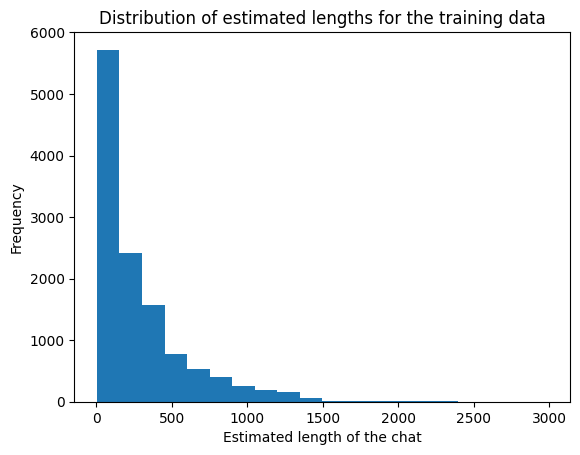

In [ ]:
# Estimation of max_length in train_reward_dataset, and the distribution of it

max_length = 0
store_length = []

for data in train_reward_dataset:
  
  length = len(data['chat'].split())

  # Update max_length
  if length > max_length:
    max_length = length

  # Store the length estimation
  store_length.append(length)

print("Max length:", max_length)

# Plot distribution of the estimated lengths
plt.hist(store_length, bins=20)
plt.title("Distribution of estimated lengths for the training data")
plt.xlabel("Estimated length of the chat")
plt.ylabel("Frequency")
plt.show()

**=> We will use max_length=500 in the tokenizer.**

In [ ]:
# Save train, test and pairs datasets
train_reward_dataset.save_to_disk(ROOT_PATH+'/data/train_reward_dataset')
test_reward_dataset.save_to_disk(ROOT_PATH+'/data/test_reward_dataset')
pairs_test_reward_dataset.save_to_disk(ROOT_PATH+'/data/pairs_test_reward_dataset')

Saving the dataset (0/1 shards):   0%|          | 0/12144 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1350 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/996 [00:00<?, ? examples/s]

### 4.2. Train

In [25]:
# Load train dataset
train_reward_dataset = load_from_disk(ROOT_PATH+'/data/train_reward_dataset')
test_reward_dataset = load_from_disk(ROOT_PATH+'/data/test_reward_dataset')
pairs_test_reward_dataset = load_from_disk(ROOT_PATH+'/data/pairs_test_reward_dataset')

In [26]:
# Checking
train_reward_dataset[0:2]

{'entry_id': [7638, 7446],
 'sol_id': ['m2_reward_2668657', 'm2_reward_2668657'],
 'label': [3, 4],
 'chat': ['System: Pretend you are an expert in neuroscience\n\nHuman: \nQ: What is a GABAergic substance ? \nA: Something is GABAergic or GABAnergic if it pertains to or affects the neurotransmitter GABA. A substance is GABAergic if it produces its  effects via interactions with the GABA system, such as by stimulating or blocking neurotransmission. A GABAergic or GABAnergic agent is any  chemical that modifies the effects of GABA in the body or brain. Some different classes of GABAergic drugs include agonists, antagonists, modulators, reuptake inhibitors and enzymes. \nQ: What did the standardized study of synaptic dynamics lead to?\n\nAssistant: A: The standardized study of synaptic dynamics has led to a better understanding of how neurons communicate with each other in the brain. It has allowed scientists to investigate the mechanisms that underlie synaptic plasticity, which is the ab

In [27]:
# Put data with the same sol_id in the same batch

def batches_same_sol_id(data):

  # Create a dictionary to store the samples grouped by sol_id
  grouped_samples = defaultdict(list)
  for sample in data:
      sol_id = sample['sol_id']
      grouped_samples[sol_id].append(sample)

  # Create a list of batches
  batches = []
  for sol_id, samples in grouped_samples.items():
      num_samples = len(samples)
      if num_samples == 3:
          sample_combinations = combinations(samples, 2)
          sorted_combinations = [sorted(x, key=lambda x: x['label']) for x in sample_combinations]
          batches.append(sorted_combinations)
  
  return batches

In [28]:
# Create DataLoader objects
train_reward_dataloader = DataLoader(batches_same_sol_id(train_reward_dataset), shuffle=True)
test_reward_dataloader = DataLoader(batches_same_sol_id(test_reward_dataset), shuffle=True)

In [29]:
# Instantiate the tokenizer, model, optimizer and loss

tokenizer = CustomRewardModelTokenizer()

model_config = CustomRewardModelConfig()
model = CustomRewardModel(model_config)
model = model.to(DEVICE)

BATCH_SIZE = 3

lr = 1e-4  # learning rate
optimizer = optim.Adam(model.parameters(), lr=lr)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model has {num_params:,} trainable parameters')

The model has 435,062,785 trainable parameters


In [30]:
def predict(batch, tokenizer, model):
  """Get predictions from the model"""

  # Encode the batch using the tokenizer
  bad_encoded = tokenizer(
                      [x[0]['chat'][0] for x in batch],
                      return_tensors="pt",
                      truncation=True,
                      padding=True,
                      max_length=500
                      )  
  
  good_encoded = tokenizer(
                      [x[1]['chat'][0] for x in batch],
                      return_tensors="pt",
                      truncation=True,
                      padding=True,
                      max_length=500
                      )  
    
  # Get predictions from the model
  sig_diff = model(bad_encoded, good_encoded)
  
  return sig_diff

In [31]:
def train(tokenizer, model, train_loader, optimizer):
  """
  Main training pipeline.
  """
    
  # Set the model to training mode
  model.train()
    
  # Training loop
  for epoch in range(2):

    epoch_loss = 0
    count = 0
    store_data_training = []
        
    print(f'=== Epoch: {epoch} ===')
        
    for i, batch in enumerate(tqdm(train_loader, desc='Training '), 0):

      count += BATCH_SIZE
            
      # Forward pass
      sig_diff = predict(batch, tokenizer, model)
      sig_diff = sig_diff.view(-1)
      sig_diff = sig_diff.clone().detach().requires_grad_(True)
            
      # Calculate loss
      log_sig_diff = torch.log(sig_diff)
      mean_log_sig_diff = log_sig_diff.mean()
      loss = mean_log_sig_diff*(-1/3)
            
      # Clear the gradient buffers of optimizer
      optimizer.zero_grad()
            
      # Backpropagate loss
      loss.backward()
            
      # Update optimizer
      optimizer.step()
            
      # Update statistics
      epoch_loss += loss.item()
      if count%(200*BATCH_SIZE)==0:
        print("loss= {}".format(epoch_loss / count))

      # Store sig_diff for further investigation
      for i in range(len(sig_diff)):
          store_data_training.append(sig_diff[i].detach().item())

  print("loss= {}".format(epoch_loss / count))
  return store_data_training

In [32]:
# Run training pipeline
store_data_training = train(tokenizer, model, train_reward_dataloader, optimizer)

=== Epoch: 0 ===


Training :   5%|▍         | 201/4048 [00:42<12:56,  4.96it/s]

loss= 0.11060837634839117


Training :  10%|▉         | 400/4048 [01:24<11:53,  5.11it/s]

loss= 0.11370803760830313


Training :  15%|█▍        | 600/4048 [02:06<12:06,  4.74it/s]

loss= 0.11463859050741626


Training :  20%|█▉        | 800/4048 [02:49<13:13,  4.09it/s]

loss= 0.11648352485693371


Training :  25%|██▍       | 1001/4048 [03:32<09:50,  5.16it/s]

loss= 0.11503529156806569


Training :  30%|██▉       | 1200/4048 [04:14<09:12,  5.16it/s]

loss= 0.11645375723795344


Training :  35%|███▍      | 1401/4048 [04:58<08:56,  4.94it/s]

loss= 0.11665514791073898


Training :  40%|███▉      | 1600/4048 [05:41<08:34,  4.76it/s]

loss= 0.1169916912257516


Training :  44%|████▍     | 1800/4048 [06:24<08:14,  4.55it/s]

loss= 0.1175601761246583


Training :  49%|████▉     | 2001/4048 [07:06<06:48,  5.01it/s]

loss= 0.11702544692593317


Training :  54%|█████▍    | 2200/4048 [07:48<06:31,  4.73it/s]

loss= 0.11639530095582207


Training :  59%|█████▉    | 2400/4048 [08:31<04:53,  5.61it/s]

loss= 0.11616721410252567


Training :  64%|██████▍   | 2600/4048 [09:14<05:22,  4.49it/s]

loss= 0.11623813030071174


Training :  69%|██████▉   | 2801/4048 [09:58<04:38,  4.48it/s]

loss= 0.11648106165629413


Training :  74%|███████▍  | 3001/4048 [10:41<03:01,  5.77it/s]

loss= 0.11601104444265366


Training :  79%|███████▉  | 3201/4048 [11:24<03:02,  4.64it/s]

loss= 0.11683134995012855


Training :  84%|████████▍ | 3400/4048 [12:05<02:15,  4.78it/s]

loss= 0.11688230198808014


Training :  89%|████████▉ | 3601/4048 [12:48<01:36,  4.62it/s]

loss= 0.11632428099728982


Training :  94%|█████████▍| 3801/4048 [13:30<00:54,  4.50it/s]

loss= 0.11622606731314016


Training :  99%|█████████▉| 4000/4048 [14:13<00:08,  5.74it/s]

loss= 0.11580971729600181


Training : 100%|██████████| 4048/4048 [14:23<00:00,  4.69it/s]


=== Epoch: 1 ===


Training :   5%|▍         | 201/4048 [00:42<12:48,  5.00it/s]

loss= 0.1115610881180813


Training :  10%|▉         | 400/4048 [01:25<13:57,  4.36it/s]

loss= 0.11657859914315244


Training :  15%|█▍        | 601/4048 [02:08<10:52,  5.28it/s]

loss= 0.11466951525252726


Training :  20%|█▉        | 801/4048 [02:51<10:50,  4.99it/s]

loss= 0.11595389801232765


Training :  25%|██▍       | 1000/4048 [03:34<09:50,  5.17it/s]

loss= 0.11600577894877642


Training :  30%|██▉       | 1201/4048 [04:17<09:58,  4.75it/s]

loss= 0.11478605199061954


Training :  35%|███▍      | 1400/4048 [05:00<09:23,  4.70it/s]

loss= 0.11518158947405893


Training :  40%|███▉      | 1600/4048 [05:42<09:39,  4.22it/s]

loss= 0.11489385980782875


Training :  44%|████▍     | 1800/4048 [06:24<07:48,  4.79it/s]

loss= 0.11513770116268898


Training :  49%|████▉     | 2001/4048 [07:08<07:06,  4.80it/s]

loss= 0.11626106207584962


Training :  54%|█████▍    | 2200/4048 [07:51<06:19,  4.86it/s]

loss= 0.11623325935579046


Training :  59%|█████▉    | 2400/4048 [08:34<06:07,  4.49it/s]

loss= 0.11556618335747366


Training :  64%|██████▍   | 2600/4048 [09:16<04:32,  5.32it/s]

loss= 0.11571640651350698


Training :  69%|██████▉   | 2801/4048 [09:59<04:02,  5.15it/s]

loss= 0.11552888124748799


Training :  74%|███████▍  | 3000/4048 [10:42<03:40,  4.76it/s]

loss= 0.11516116759646684


Training :  79%|███████▉  | 3201/4048 [11:25<02:29,  5.66it/s]

loss= 0.11473478111331739


Training :  84%|████████▍ | 3401/4048 [12:06<02:19,  4.65it/s]

loss= 0.1148662252697692


Training :  89%|████████▉ | 3600/4048 [12:48<01:36,  4.64it/s]

loss= 0.11551840445639014


Training :  94%|█████████▍| 3800/4048 [13:32<00:54,  4.54it/s]

loss= 0.11556574253422584


Training :  99%|█████████▉| 4001/4048 [14:14<00:10,  4.63it/s]

loss= 0.11573598224972374


Training : 100%|██████████| 4048/4048 [14:24<00:00,  4.68it/s]

loss= 0.11576946122240218


In [33]:
 # Save model

def save_reward_model(reward_model, model_path):
    """Save the model and tokenizer to the specified path"""
    reward_model.save_pretrained(model_path)
    reward_model.config.save_pretrained(model_path)


save_reward_model(model, ROOT_PATH+"/reward_model")

In [34]:
# Save store_data_training
with open(ROOT_PATH+"/data/store_data_training", "wb") as fp:   #Pickling
  pickle.dump(store_data_training, fp)

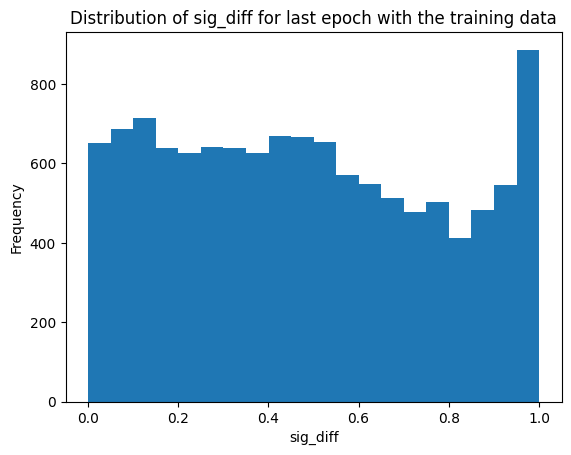

In [35]:
# Look at the distribution of the scores over all epochs
plt.hist([sig_diff for sig_diff in store_data_training], bins=20)
plt.title("Distribution of sig_diff for last epoch with the training data")
plt.xlabel("sig_diff")
plt.ylabel("Frequency")
plt.show()

## 5. Evaluate the Reward model

In [36]:
def evaluate(model, test_loader):
  """Evaluate the model on the test dataset"""
  
  count = 0
  total_loss = 0
  all_pred, all_target = [], []
  model.eval()
  store_data_evaluation = []

  for batch in tqdm(test_loader):
    with torch.no_grad():

      count += BATCH_SIZE
      
      sig_diff = predict(batch, tokenizer, model)
      sig_diff = sig_diff.view(-1)
            
      # Calculate loss
      log_sig_diff = torch.log(sig_diff)
      mean_log_sig_diff = log_sig_diff.mean()
      loss = mean_log_sig_diff*(-1/3)
      
      total_loss += loss.item()

      # Store sig_diff for further investigation
      for i in range(len(sig_diff)):
          store_data_evaluation.append(sig_diff[i].detach().item())

  print(f"Evaluation Complete: \nLoss: {total_loss/count}")
  return store_data_evaluation

In [37]:
store_data_evaluation = evaluate(model, test_reward_dataloader)

100%|██████████| 450/450 [01:20<00:00,  5.62it/s]

Evaluation Complete: 
Loss: 0.12325221522400777


In [38]:
# Save store_data_evaluation
with open(ROOT_PATH+"/data/store_data_evaluation", "wb") as fp:   #Pickling
  pickle.dump(store_data_evaluation, fp)

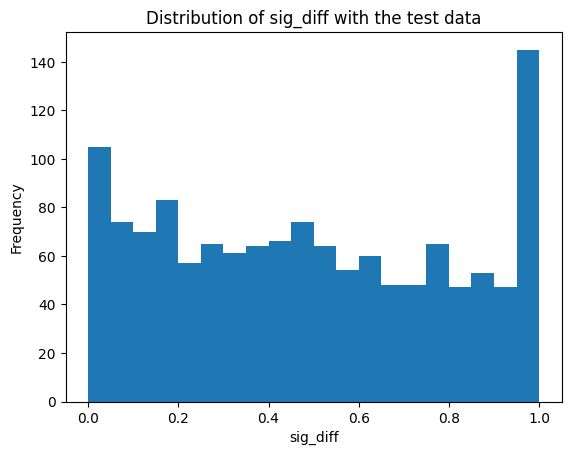

In [39]:
# Look at the distribution of the scores over all epochs
plt.hist([sig_diff for sig_diff in store_data_evaluation], bins=20)
plt.title("Distribution of sig_diff with the test data")
plt.xlabel("sig_diff")
plt.ylabel("Frequency")
plt.show()

In [40]:
# Check if solutions scores better than interactions scores

count_sol_better = 0
count_tot = 0
count_sol_better_Not5 = 0
count_tot_Not5 = 0
unique_sol_ids = {data['sol_id'] for data in pairs_test_reward_dataset}

for sol_id in tqdm(unique_sol_ids):
    
    sol_id_data = [data for data in pairs_test_reward_dataset if data.get('sol_id') == sol_id]
    sol_id_data = Dataset.from_dict({key: [item[key] for item in sol_id_data] for key in sol_id_data[0]})
    scores = model.get_score(sol_id_data['chat']).detach().tolist()
    targets = sol_id_data['label']
    sources = sol_id_data['source']

    score_solution = [scores[i] for i, val in enumerate(sources) if val=='solutions dataset'][0]
    scores_interactions = [scores[i] for i, val in enumerate(sources) if val=='interactions dataset']
    targets_interactions = [targets[i] for i, val in enumerate(sources) if val=='interactions dataset']

    count_sol_better += sum(1 for score_interactions in scores_interactions if score_solution>score_interactions)
    count_tot += len(scores_interactions)

    scores_interactions_Not5 = list(compress(scores_interactions, [targets_interactions[i]!=5 for i in range(len(targets_interactions))]))
    count_sol_better_Not5 += sum(1 for score_interactions in scores_interactions_Not5 if score_solution>score_interactions)
    count_tot_Not5 += len(scores_interactions_Not5)

    #print('For sol_id={}:'.format(sol_id))
    #print('scores={}'.format(scores))
    #print('targets={}'.format(targets))
    #print('sources={}'.format(sources))

print("\nscore total: {:.2f}%".format(count_sol_better/count_tot*100))
print("score without interaction_score=5: {:.2f}%".format(count_sol_better_Not5/count_tot_Not5*100))

100%|██████████| 332/332 [00:52<00:00,  6.37it/s]


score total: 28.61%
score without interaction_score=5: 28.27%


## 6. Save the Reward model and its tokenizer

In [ ]:
def save_reward_model(reward_model, model_path):
    """Save the model and tokenizer to the specified path"""
    reward_model.save_pretrained(model_path)
    reward_model.config.save_pretrained(model_path)

In [ ]:
save_reward_model(model, ROOT_PATH+"/reward_model")

## 7. Checking

### 7.1. Check the opening and the use of our custom model and its tokenizer

In [41]:
# Import and open

from transformers import AutoModel, AutoTokenizer, AutoConfig, AutoModelForSequenceClassification
from reward_model import CustomRewardModelConfig, CustomRewardModel
import torch

AutoConfig.register('CustomRewardModel', CustomRewardModelConfig)
AutoModel.register(CustomRewardModelConfig, CustomRewardModel)

config = AutoConfig.from_pretrained(ROOT_PATH+"/reward_model")
model = AutoModel.from_pretrained(ROOT_PATH+"/reward_model", config=config)

# Set device
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = model.to(DEVICE)

In [42]:
# Check
for i, batch in enumerate(tqdm(test_reward_dataloader), 0):
  if i == 0:
    print(model.get_score([x[0]['chat'][0] for x in batch]))
  else:
    break

  0%|          | 1/450 [00:00<01:08,  6.56it/s]

tensor([[-1.0262],
        [-1.0262],
        [ 0.0181]], device='cuda:0', grad_fn=<AddmmBackward0>)


### 7.2. Check with the evaluation.py file

In [43]:
# Import

from transformers import AutoModel, AutoConfig
from reward_model import CustomRewardModelConfig, CustomRewardModel
from evaluate_reward_model import Reward, Evaluator
import json

def load_json(filename):
    """Load json file"""
    with open(filename, 'r') as read_file:
        data = json.load(read_file)
    return data

In [44]:
# Check

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

AutoConfig.register('CustomRewardModel', CustomRewardModelConfig)
AutoModel.register(CustomRewardModelConfig, CustomRewardModel)

reward_dataset_evaluationTA = load_json(ROOT_PATH+"/data/m2_reward_dataset_evaluationTA.json")
reward = Reward(ROOT_PATH+"/reward_model")

evaluator = Evaluator(ROOT_PATH+"/reward_model", reward_dataset_evaluationTA)
evaluator.model.model.to(DEVICE)
evaluator.evaluate()

100%|██████████| 3/3 [00:00<00:00,  5.23it/s]

Evaluation Complete, Accuracy: 1.0


In [ ]:
# More checking
!python {ROOT_PATH}"/evaluate.py" --model_path {ROOT_PATH}"/reward_model" --data_path {ROOT_PATH}"/data/m2_reward_dataset_evaluationTA.json"